# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import CDFPermutationTest, ChiSquareTest, PermutationTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [3]:
from darwinian_shift.additional_plotting_functions import plot_scatter_two_scores

In [4]:
from darwinian_shift.utils.sifts_functions import get_sifts_alignment
import os

# Setup

In [5]:
# Define the region to test
notch1_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000277541', 'pdb_id': '2vj3', 'pdb_chain': 'A', 
    'start': 412, 'end': 488 # Restrict to the residues in EGF11-12
}

notch2_section_definition_egf11_12 = {
    'transcript_id': 'ENST00000256646', 'pdb_id': '5mwb', 'pdb_chain': 'A', 
    'start': 415, 'end': 492 # Restrict to the residues in EGF11-12
}

In [6]:
# Define the mutational spectra
main_fig_spectrum=GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=False,  # Do not remove duplicate mutations when calculating the spectrum
        name=''  # Use a blank name, so in the plots it will just say "Expected"
    )

In [7]:
# Define the statistical tests

cdf_perm = CDFPermutationTest(num_permutations=100000, testing_random_seed=0)  # Used to calculate p-values

chi_sq = ChiSquareTest(bins=[-0.1, 0.5, 1.1])  # Used to calculate counts for the discrete metrics

stats = [cdf_perm, chi_sq]

In [8]:
# Make a DarwinianShift object for the project. 
# This calculates the mutational spectrum, sets up the statistical tests to use, and filters the data. 
d = DarwinianShift(
    data="SMS-35_merged_sorted.txt", 
    source_genome='GRCh37',
    spectra=main_fig_spectrum,
    stats=[cdf_perm, chi_sq],
    
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

/Users/mh28/miniconda3/envs/ds/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [9]:
plot_directory="."
    
sifts_directory="."
pdb_directory = "."

In [10]:
# Colours

unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'

foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'

interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'

calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Defining all of the selected features

## FoldX

In [11]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="./FoldX_results",
                      sifts_directory=sifts_directory,
                      foldx_file_name_start="PS_f*", download_sifts=True)

In [12]:
d_fold_all = d.change_lookup(fold)
s_fold_all_notch1 = d_fold_all.run_section(notch1_section_definition_egf11_12, statistics=[cdf_perm])

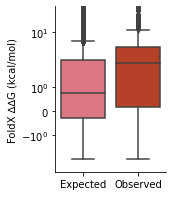

In [13]:
s_fold_all_notch1.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.tight_layout()

## Interface

In [14]:
# # Using the interface residues defined in Luca et al 2017
notch1_section_definition_egf11_12['interface_residues'] = [413, 415, 418, 420, 421, 422, 423, 424, 425, 
                                                     435, 436, 444, 447, 448, 450, 451, 452, 454, 
                                                     466, 467, 468, 469, 470, 471, 475, 477, 478, 
                                                     479, 480]

In [15]:
# Define a lookup object which determines whether mutations are on the NOTCH1-ligand interface. 
interface_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean on/off interface. 
    target_key='interface_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='On interface'  # Label to appear on plot axes
)

## Calcium binding

Using the server MetalPDB https://academic.oup.com/nar/article/46/D1/D459/4564802  
http://metalweb.cerm.unifi.it

In [16]:
# Add the residues to the section definition dictionary.  
notch1_ca_binding_residues = [412, 413, 415, 431, 432, 435, 452, 453, 455, 469, 470]
notch1_section_definition_egf11_12['ca_binding_residues'] = notch1_ca_binding_residues

In [17]:
ca_lookup = SequenceDistanceLookup(
    boolean=True,   # Just a boolean binding/not binding. 
    target_key='ca_binding_residues',   # Use this entry in the section_definition dict to define the target residues
    position_type='residue',   # Use the residue number (as opposed to cdspos or chromosomal position)
    name='Calcium binding'  # Label to appear on plot axes
)

# Testing selection

## FoldX

In [18]:
# First define a lookup that is 1 if the mutation is on the interface and or calcium binding
interface_or_ca_lookup = ORLookup(
    lookups=[interface_lookup, ca_lookup],  
    thresholds=[0.5, 0.5],  # Set thresholds at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for interface or calcium binding.
)


# Define the combined lookup.
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_or_ca_lookup,
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=fold.name
)

In [19]:
d_fold = d.change_lookup(excllook_foldx)

In [20]:
s_fold_notch1 = d_fold.run_section(notch1_section_definition_egf11_12, statistics=[cdf_perm])

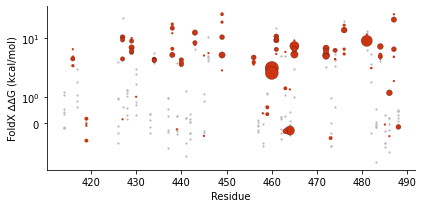

In [21]:
s_fold_notch1.plot_scatter(figsize=(6, 3), plot_scale='symlog', show_legend=False, 
                    unobserved_mutation_colour=unobserved_colour, 
                    missense_mutation_colour=foldx_observed_colour, 
                    unmutated_marker_size=5, base_marker_size=5,
                   )
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'notch1_scatter_foldx_efg11_12.pdf'), transparent=True)

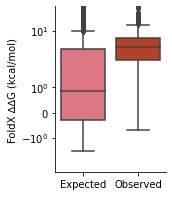

In [22]:
s_fold_notch1.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'notch1_boxplot_foldx_efg11_12.pdf'), transparent=True)

In [23]:
s_fold_notch1_results = s_fold_notch1.get_results_dictionary()

In [24]:
s_fold_notch1_results['num_mutations']

452

In [25]:
s_fold_notch1.get_pvalues()

{'CDF_perm__pvalue': 1.999980000199998e-05}

## Interface residues

In [26]:
# First define a lookup that is 1 if the mutation is destabilising or calcium binding
destabilising_or_ca_lookup = ORLookup(
    lookups=[fold, ca_lookup],  
    thresholds=[2, 0.5],  # Use 2kcal/mol as the ∆∆G threshold. Ca score is 0 or 1, so set threshold at 0.5
    directions=[1, 1],  # Want to exclude mutations which score 1 for calcium binding or > 2 for ∆G.
)


# Define the combined lookup.
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_ca_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=interface_lookup.name
)

In [27]:
d_interface1 = d.change_lookup(excllook_interface)

In [28]:
s_interface_notch1 = d_interface1.run_section(notch1_section_definition_egf11_12)

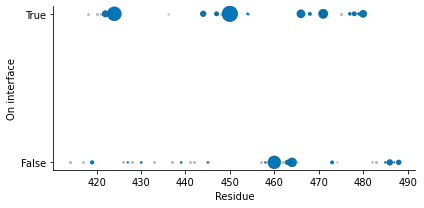

In [29]:
s_interface_notch1.plot_scatter(figsize=(6, 3), show_legend=False, 
                          unobserved_mutation_colour=unobserved_colour, 
                          missense_mutation_colour=interface_observed_colour, 
                         base_marker_size=5, unmutated_marker_size=5)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'notch1_scatter_interface_efg11_12.pdf'), transparent=True)

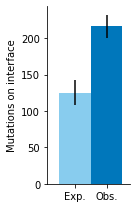

In [30]:
s_interface_notch1.plot_binned_counts(figsize=(2, 3), show_legend=False, 
                                      colours=[interface_observed_colour, interface_expected_colour])
plt.xlim(left=0.75)
# plt.ylim(top=35)
plt.title("")
plt.xticks([1.1, 1.5], ['Exp.', 'Obs.'], rotation=0)
plt.ylabel('Mutations on interface')
hide_top_and_right_axes(plt.gca())
plt.tight_layout()
plt.savefig(os.path.join(plot_directory,"notch1_bar_interface_efg11_12.pdf"),  transparent=True);

In [31]:
s_interface_notch1_results = s_interface_notch1.get_results_dictionary()

In [32]:
s_interface_notch1_results['num_mutations']

315

In [33]:
s_interface_notch1_results['CDF_perm__pvalue']  # P-value of the permutation test

1.999980000199998e-05

## Calcium binding residues

In [34]:
# First define a lookup that is 1 if the mutation is destabilising or on the interface and 0 otherwise.
destabilising_or_interface_lookup = ORLookup(
    lookups=[fold, interface_lookup],  # Use the FoldX and the interface lookups.  
    thresholds=[2, 0.5],  # Again pick a threshold of 2kcal/mol for the FoldX result, interface results are either 0 or 1 so set threshold at 0.5. 
    directions=[1, 1],  # Want to exclude mutations with scores greater than the thresholds, so directions are both 1.
)


# Define the combined lookup.
excllook_ca = MutationExclusionLookup(
    lookup=ca_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=destabilising_or_interface_lookup,   
    exclusion_threshold=0.5,  #  Scores from the exclusion are either 0, or 1, so can put threshold anywhere in between.
    exclusion_direction=1,   # Exclude mutations with a score above the exclusion_threhold from the exclusion_lookup.
    name=ca_lookup.name
)

In [35]:
d_ca2 = d.change_lookup(excllook_ca)

In [36]:
s_ca_notch1 = d_ca2.run_section(notch1_section_definition_egf11_12)

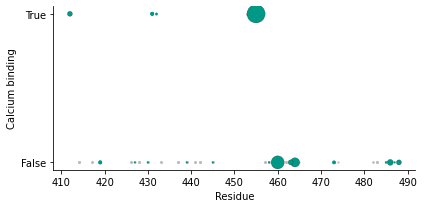

In [37]:
s_ca_notch1.plot_scatter(figsize=(6, 3), show_legend=False, 
                  unobserved_mutation_colour=unobserved_colour, 
                   missense_mutation_colour=calcium_observed_colour,
                  base_marker_size=5, unmutated_marker_size=5)
plt.yticks([0, 1], ['False', 'True']);
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'notch1_scatter_ca_efg11_12.pdf'), transparent=True)

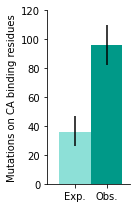

In [38]:
s_ca_notch1.plot_binned_counts(figsize=(2, 3), show_legend=False, 
                                      colours=[calcium_observed_colour, calcium_expected_colour])
plt.xlim(left=0.75)
plt.ylim(top=120)
plt.title("")
plt.xticks([1.1, 1.5], ['Exp.', 'Obs.'], rotation=0)
plt.ylabel('Mutations on CA binding residues')
hide_top_and_right_axes(plt.gca())
plt.tight_layout()
plt.savefig(os.path.join(plot_directory,"notch1_bar_ca_efg11_12.pdf"),  transparent=True);

In [39]:
s_ca_notch1_results = s_ca_notch1.get_results_dictionary()

In [40]:
s_ca_notch1_results['num_mutations']

195

In [41]:
s_ca_notch1_results['CDF_perm__pvalue']  # P-value of permutation test

1.999980000199998e-05